In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
from hydra import initialize, compose
from rdkit import Chem
from collections import defaultdict
from ergochemics.mapping import rc_to_nest
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
from cgr.ml import bin_label_to_sep_aidx
import yaml
from ast import literal_eval
from ergochemics.mapping import (
    get_reaction_center
)

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score
)

from sklearn.calibration import CalibrationDisplay

with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

mlflow.set_tracking_uri(f"file://{cfg.mlruns}")

In [3]:


def get_min_dist_to_rc(am_rxn: str, rc: list[list[list[int]], list[list[int]]]) -> list[list[list[int]], list[list[int]]]:
    mols = [[Chem.MolFromSmiles(elt) for elt in side.split('.')] for side in am_rxn.split('>>')]
    min_dists = [[], []]
    for i, side_rc in enumerate(rc):
        for mol, rc in zip(mols[i], side_rc):
            for atom in mol.GetAtoms():
                aidx = atom.GetIdx()
                min_dist = min(len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0 for rcidx in rc)

                min_dists[i].append(min_dist)
    return [np.array(elt).reshape(-1, 1) for elt in min_dists]


In [4]:
experiment_name = "production"
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    df = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
else:
    print(f"Experiment '{experiment_name}' not found.")

In [5]:
df.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.epoch,params.model/featurizer_mode,params.full/training/final_lr,...,params.full/data/inner_splitter,params.init_lr,params.training/max_lr,params.training/batch_size,params.pos_weight,params.data/split_strategy,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.runName,tags.mlflow.user
0,1761c4a9a8b24ea684bd720a1cb12340,935416590272618137,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-22 13:54:11.043000+00:00,2025-05-22 13:58:54.205000+00:00,0.166724,4.0,PROD_DIFF,0.001,...,True,0.0001,0.0001,102,1.9779151739397054,random_rule_split,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,LOCAL,resilient-lamb-795,spn1560
1,0e39101a0d7a47c084a26b5acb82443d,935416590272618137,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-22 13:54:07.118000+00:00,2025-05-22 13:58:33.155000+00:00,0.089527,6.0,PROD_DIFF,0.001,...,True,0.0001,0.0001,102,0.8612613452546635,random_rule_split,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,LOCAL,trusting-rat-988,spn1560
2,256e5a514ff647f29c39350d34fad7b8,935416590272618137,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-22 13:54:04.502000+00:00,2025-05-22 13:58:25.305000+00:00,0.093567,7.0,PROD_DIFF,0.001,...,True,0.0001,0.0001,101,1.0676097756847729,random_rule_split,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,LOCAL,popular-quail-914,spn1560
3,f6db007653614100b69c511fc4a2fed3,935416590272618137,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-22 13:54:04.502000+00:00,2025-05-22 13:58:36.859000+00:00,0.095977,8.0,PROD_DIFF,0.001,...,True,0.0001,0.0001,106,0.9554529127701415,random_rule_split,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,LOCAL,handsome-pug-553,spn1560
4,94186c8bb3c84da4a879baf1868d8f5e,935416590272618137,FINISHED,file:///home/spn1560/coarse-grain-rxns/artifac...,2025-05-22 13:54:01.190000+00:00,2025-05-22 14:04:41.152000+00:00,0.120764,17.0,PROD_DIFF,0.001,...,True,0.0001,0.0001,115,2.2855703725004988,random_rule_split,/gpfs/home/spn1560/coarse-grain-rxns/.venv/lib...,LOCAL,traveling-worm-90,spn1560


In [6]:
# Copy configs to conf dir to train production model
for i, row in df.iterrows():
    fn = f"outer_split_{row['params.data/outer_split_idx']}.yaml"
    out_path = Path(cfg.configs) / "production" / fn
    artifact_dir = Path(row['artifact_uri'].replace("file:///home/spn1560/coarse-grain-rxns", "/home/stef/cgr"))
    model_ckpt_abs = next(artifact_dir.rglob("*.ckpt"))
    model_ckpt_rel = model_ckpt_abs.relative_to(cfg.mlruns)
    print("checkpoint: ", model_ckpt_rel)

    config = defaultdict(dict)
    for k, v in row.items():
        if k.startswith("params.") and "/" in k:
            k_out, k_in, *_ = k.removeprefix("params.").split("/")

            if k_out == "full":
                continue

            try:
                config[k_out][k_in] = literal_eval(v)
            except ValueError:
                config[k_out][k_in] = v
    
    config["model"]["ckpt"] = str(model_ckpt_rel)

    with open(out_path, "w") as f:
        yaml.dump(dict(config), f)
    
    print(f"Saving config to: {out_path}")

checkpoint:  935416590272618137/1761c4a9a8b24ea684bd720a1cb12340/artifacts/epoch=4-step=400/epoch=4-step=400.ckpt
Saving config to: /home/stef/cgr/configs/production/outer_split_3.yaml
checkpoint:  935416590272618137/0e39101a0d7a47c084a26b5acb82443d/artifacts/epoch=6-step=560/epoch=6-step=560.ckpt
Saving config to: /home/stef/cgr/configs/production/outer_split_0.yaml
checkpoint:  935416590272618137/256e5a514ff647f29c39350d34fad7b8/artifacts/epoch=7-step=648/epoch=7-step=648.ckpt
Saving config to: /home/stef/cgr/configs/production/outer_split_2.yaml
checkpoint:  935416590272618137/f6db007653614100b69c511fc4a2fed3/artifacts/epoch=8-step=693/epoch=8-step=693.ckpt
Saving config to: /home/stef/cgr/configs/production/outer_split_1.yaml
checkpoint:  935416590272618137/94186c8bb3c84da4a879baf1868d8f5e/artifacts/epoch=17-step=1278/epoch=17-step=1278.ckpt
Saving config to: /home/stef/cgr/configs/production/outer_split_4.yaml


In [35]:
preds = []
for fn in (Path(cfg.processed_data) / "mech_probas").glob("*.parquet"):
    print("Loading: ", fn)
    preds.append(pd.read_parquet(fn))

pred_df = pd.concat(preds)
pred_df = pred_df.groupby(["rxn_id", "aidx"]).agg({"probas": ["mean", "std"]}).reset_index()
pred_df.head()

Loading:  /home/stef/cgr/data/processed/mech_probas/2.parquet
Loading:  /home/stef/cgr/data/processed/mech_probas/1.parquet
Loading:  /home/stef/cgr/data/processed/mech_probas/3.parquet
Loading:  /home/stef/cgr/data/processed/mech_probas/4.parquet
Loading:  /home/stef/cgr/data/processed/mech_probas/0.parquet


rxn_id aidx    probas          
                   mean       std
0      0    0  0.012415  0.005113
1      0    1  0.061208  0.050467
2      0    2  0.011885  0.005061
3      0    3  0.024794  0.024259
4      0    4  0.996109  0.003210

In [9]:
full = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_sprhea_240310_v3_mapped_no_subunits_x_rc_plus_0_rules.parquet"
)
full["rxn_id"] = full["rxn_id"].astype(int)
full["template_aidxs"] = full["template_aidxs"].apply(rc_to_nest)
full["reaction_center"] = full["am_smarts"].apply(get_reaction_center) # Get the actual reaction center from the atom mapped reactions
# full["min_dist_to_rc"] = full.apply(lambda x: get_min_dist_to_rc(x.am_smarts, x.reaction_center)[0], axis=1) # Get min dist to reaction center for lhs
# full["binary_label"] = full.apply(lambda x: sep_aidx_to_bin_label(x.am_smarts, x.template_aidxs)[0], axis=1) # Convert aidxs to binary labels for block mol
full.head()

,rxn_id,smarts,am_smarts,rule,template_aidxs,rule_id,reaction_center
0,0,NC(CCC=O)C(=O)O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O...,[NH2:7][CH:6]([CH2:5][CH2:3][CH:1]=[O:4])[C:8]...,[#6:1].[#6:2]1:[#6:3]:[#6:4]:[#6:5]:[#7+:6]:[#...,"(((4,), (3, 4, 5, 6, 7, 47), (2,)), ((4, 6), (...",819,"[[[4], [3, 47, 7, 6, 5, 4], [2]], [[4, 6], [3,..."
1,1,CC(O)C(O)C(O)C(O)C(=O)O>>CC(O)C(O)CC(=O)C(=O)O.O,[CH3:7][CH:5]([OH:8])[CH:4]([OH:6])[CH:1]([OH:...,([#6:1]-[#8:2].[#6:3]-[#8:4])>>([#6:1].[#6:3]=...,"(((5, 6, 7, 8),), ((5, 6, 7), (0,)))",402,"[[[5, 7, 8, 6]], [[5, 6, 7], [0]]]"
2,10,CCCCCCCCCCCC(=O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc...,[CH3:14][CH2:13][CH2:12][CH2:11][CH2:10][CH2:9...,[#6:1]-[#8:2].[#8:3]-[#15:4]>>[#6:1]-[#8:3].[#...,"(((11, 13), (2, 1)), ((11, 13), (18, 19)))",994,"[[[11, 13], [2, 1]], [[11, 13], [18, 19]]]"
3,100,*C(=O)OCC(COP(=O)(O)OC1C(O)C(OP(=O)(O)O)C(O)C(...,[*:30][C:27](=[O:31])[O:25][CH2:23][CH:22]([CH...,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],"(((15, 16), (0,)), ((15, 16), (2,)))",517,"[[[15, 16], [0]], [[15, 16], [2]]]"
4,1000,CCC=O.NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)...,[CH3:5][CH2:3][CH:1]=[O:4].[NH2:13][C:12](=[O:...,[#6:1].[#6:2]1:[#6:3]:[#6:4]:[#6:5]:[#7+:6]:[#...,"(((2,), (3, 4, 5, 6, 7, 47), (0,)), ((2, 4), (...",819,"[[[2], [3, 47, 7, 6, 5, 4], [0]], [[2, 4], [3,..."


In [30]:
dt = 0.983
pred_df["preds"] = pred_df["probas"]["mean"].apply(lambda x: x > dt)
pred_df.head()

rxn_id aidx    probas            preds
                   mean       std       
0      0    0  0.012415  0.005113  False
1      0    1  0.061208  0.050467  False
2      0    2  0.011885  0.005061  False
3      0    3  0.024794  0.024259  False
4      0    4  0.996109  0.003210   True

In [31]:
rxn_id_of_i = 1

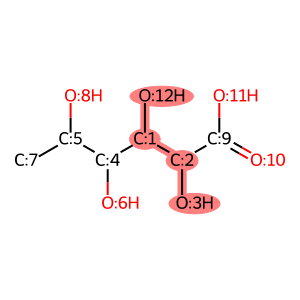

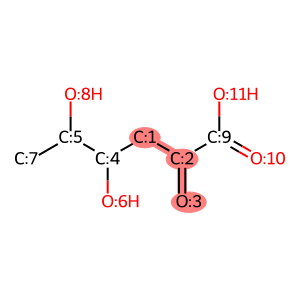

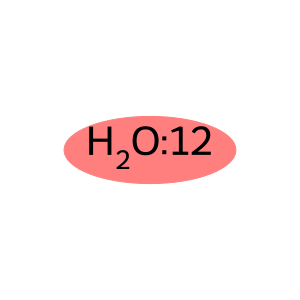

In [32]:
lhs_labels, rhs_labels = bin_label_to_sep_aidx(pred_df.loc[pred_df["rxn_id"] == rxn_id_of_i, "preds"].to_numpy(), full.loc[full["rxn_id"] == rxn_id_of_i, "am_smarts"].values[0])
lhs_mols, rhs_mols = [[Chem.MolFromSmiles(smi) for smi in side.split('.')] for side in full.loc[full["rxn_id"] == rxn_id_of_i, "am_smarts"].values[0].split('>>')]
for mol, labels in zip(lhs_mols, lhs_labels):
    display(
        SVG(
            draw_molecule(mol, highlight_atoms=labels, size=(300, 300))
        )
    )

for mol, labels in zip(rhs_mols, rhs_labels):
    display(
        SVG(
            draw_molecule(mol, highlight_atoms=labels, size=(300, 300))
        )
    )

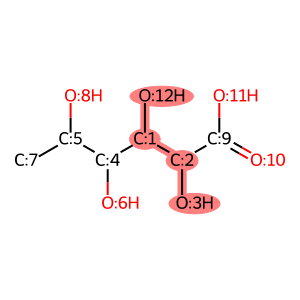

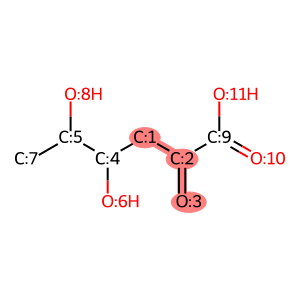

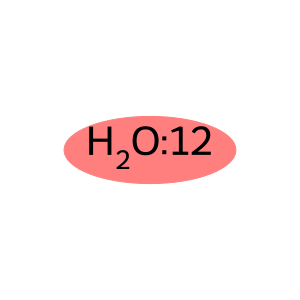

In [28]:
lhs_labels, rhs_labels = full.loc[full["rxn_id"] == rxn_id_of_i, "reaction_center"].values[0]

for mol, labels in zip(lhs_mols, lhs_labels):
    display(
        SVG(
            draw_molecule(mol, highlight_atoms=labels, size=(300, 300))
        )
    )

for mol, labels in zip(rhs_mols, rhs_labels):
    display(
        SVG(
            draw_molecule(mol, highlight_atoms=labels, size=(300, 300))
        )
    )

In [71]:
min_dist_map = dict(zip(full["rxn_id"].astype(int), full["min_dist_to_rc"]))
rule_id_map = dict(zip(full["rxn_id"].astype(int), full["rule_id"]))
pred_df["rule_id"] = pred_df["rxn_id"].map(rule_id_map)
pred_df["min_dist_to_rc"] = None
for k, v in min_dist_map.items():
    pred_df.loc[pred_df["rxn_id"] == k, "min_dist_to_rc"] = v.flatten()

pred_df.head()

,rxn_id,aidx,y,y_pred,min_dist_to_rc,rule_id
0,10,0,0.0,0.352157,4,632
1,10,1,1.0,0.936013,3,632
2,10,2,1.0,0.665277,4,632
3,10,3,0.0,0.665277,4,632
4,10,4,1.0,0.922557,2,632


In [10]:
bad_ids = set()
for _, row in full.iterrows():
    templates = row["template_aidxs"][0]
    rcs = row["reaction_center"][0]

    for template, rc in zip(templates, rcs):
        if len(set(rc) - set(template)) != 0:
            bad_ids.add(row["rxn_id"])
print(bad_ids)

{'12818', '3555', '5872', '3707', '1101', '6303', '7054', '16263', '6020', '8971'}


In [11]:
continuous_rxn_ids = []
for _, row in full.iterrows():
    continuous_rxn_ids.append(
        np.repeat(int(row["rxn_id"]), row["binary_label"].shape[0]).reshape(-1, 1)
    )

continuous_rxn_ids = np.vstack(continuous_rxn_ids)

y = np.vstack(full["binary_label"])
min_dist_rc = np.vstack(full["min_dist_to_rc"])
Rs = [0, 1, 2, 3, 4]
rcr_preds = {R: (min_dist_rc <= R).astype(np.int32) for R in Rs}
recall_from_rcr = [recall_score(y, rcr_preds[R]) for R in Rs]
precision_from_rcr = [precision_score(y, rcr_preds[R]) for R in Rs]
recall_from_rcr, precision_from_rcr

([0.5273371670807345,
  0.7103841275908198,
  0.8372800083392693,
  0.9088066158202888,
  0.965305165134905],
 [0.9993415204293287,
  0.6636855004950576,
  0.4980725307206565,
  0.4035082306113948,
  0.33884226960042935])

In [12]:
bad_ids = np.unique(continuous_rxn_ids[(rcr_preds[0] - y == 1)])
bad_ids

array([ 1101,  3555,  3707,  5872,  6020,  6303,  7054,  8971, 12818,
       16263])

In [13]:
row = full[full["rxn_id"] == '10024']
row

,rxn_id,smarts,am_smarts,rule,reaction_center,rule_id,template_aidxs,min_dist_to_rc,binary_label
10,10024,CNCC(O)c1ccccc1.Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=...,[CH3:1][NH:28][CH2:29][CH:30]([OH:31])[c:32]1[...,[C&D1&v4&H3&0*&!R&z1:1]-[N&D2&v3&H1&0*&!R:2].[...,"[[[0, 1], [14]], [[0, 1], [0]]]",42,"(((0, 1), (14,)), ((0, 1), (0,)))","[[0], [0], [1], [2], [3], [3], [4], [5], [6], ...","[[1.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0...."


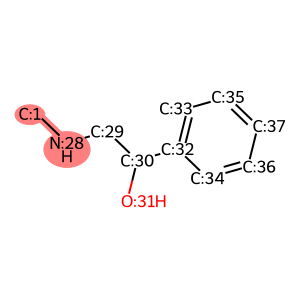

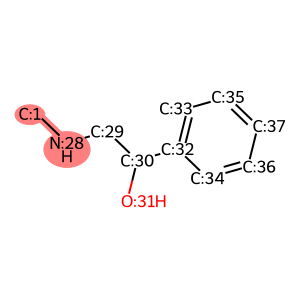

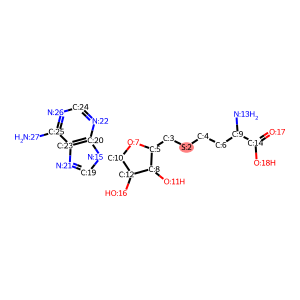

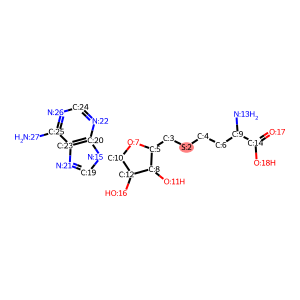

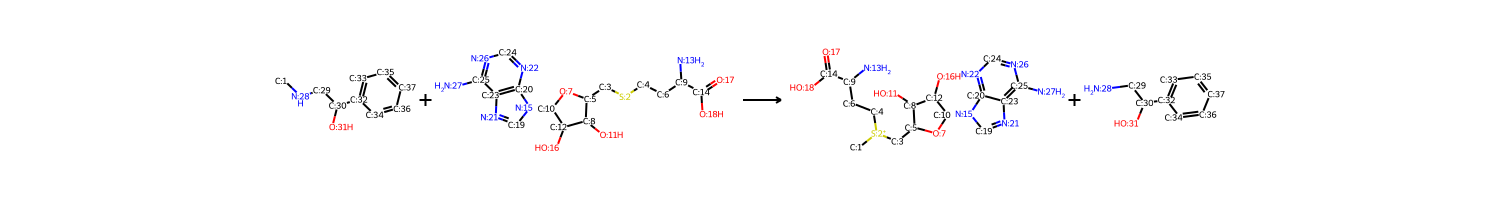

In [14]:
am_rxn = row["am_smarts"].values[0]
lhs_mols = [Chem.MolFromSmiles(elt) for elt in am_rxn.split('>>')[0].split('.')]
for i, mol in enumerate(lhs_mols):
    template = row["template_aidxs"].values[0][0][i]
    rc = row["reaction_center"].values[0][0][i]
    display(SVG(draw_molecule(lhs_mols[i], highlight_atoms=template, size=(300, 300))))
    display(SVG(draw_molecule(lhs_mols[i], highlight_atoms=rc, size=(300, 300))))
display(SVG(draw_reaction(am_rxn)))